# Chapter 2: Methodology
# Simple illustration of JME and JMEG Weights
<div class="alert alert-success">
    
This Notebook contains the Figures 1 to 3, namely the simple illustrations of JME and JMEG weights along with illustrations of cellsize effects and cType 10

In [1]:
# Importing pygimli
import  pygimli                 as     pg
import  pygimli.meshtools       as     mt
from    pygimli.physics         import ert
from    pygimli.viewer.mpl      import createColorBarOnly
from    pygimli.physics         import TravelTimeManager

# Importing auxiliary libraries
import  numpy                   as     np
import  matplotlib.pyplot       as     plt
import  sys

path = 'C:/Users/azieg/Documents/GitHub/JMEI_Paper/'

## Creating Meshes

In [2]:
# Loading SRT
fn_tt      = path+'Data/Synthetic/Synth_tt.dat'
tt_data = pg.physics.traveltime.load(fn_tt)
SRT = TravelTimeManager(tt_data)

#regular grid
x=np.arange(-65,65.5,1).tolist()
y=np.arange(-20,0.5,1).tolist()
grid = pg.createGrid(x, y, marker=1, worldBoundaryMarker=True)

#very unregular mesh
mesh2 = SRT.createMesh(tt_data, paraDepth=20, paraMaxCellSize=5, marker=1)

# finer mesh
w = mt.createWorld([-65,-20], [65, 0])
mesh1 = mt.createMesh(w,area=1., marker=1)

06/11/23 - 15:17:47 - pyGIMLi - INFO - Found 1 regions.


## Fig. 1: Cell size effects

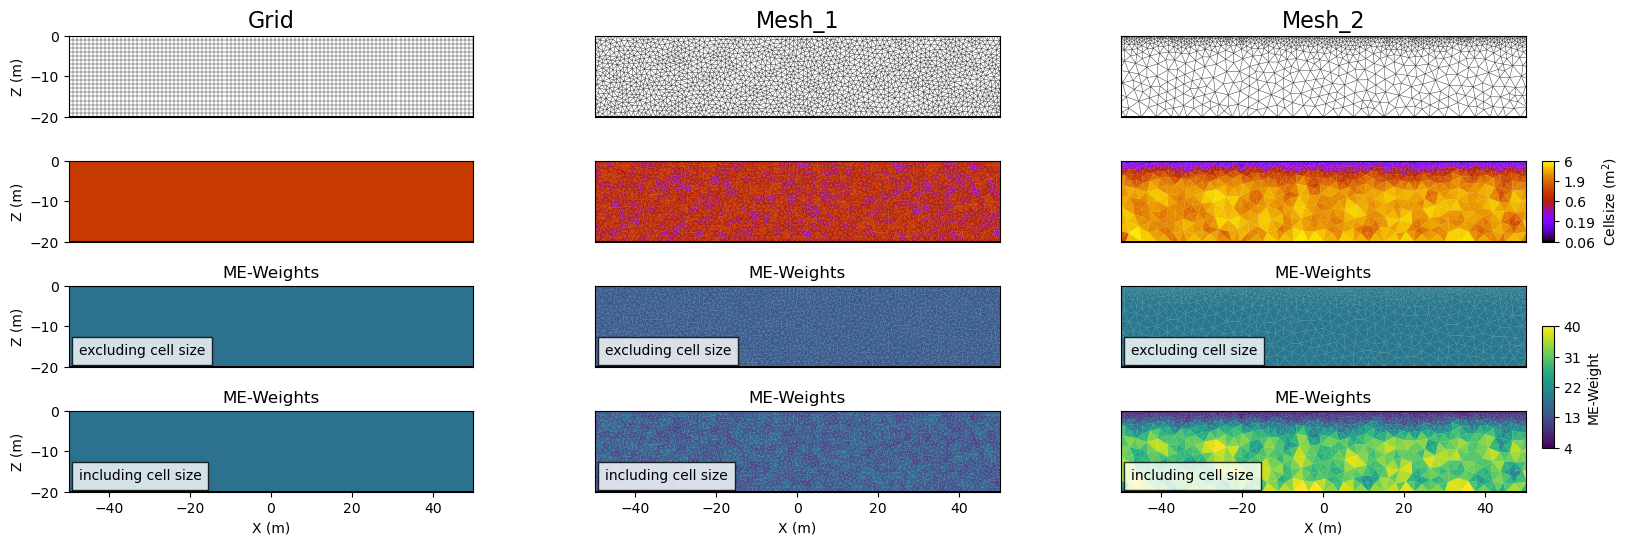

In [4]:
# Homogeneous models
grid_hom = 1000 * grid.cellMarkers()
mesh1_hom = 1000 * mesh1.cellMarkers()
mesh2_hom = 500 * mesh2.cellMarkers()

# Parameters
q=1
b=1e-5

# Normalization function
def normalize(m, m0):
    mmin = min(np.log(m))
    mmax = max(np.log(m))
    m_new = (np.log(m)-mmin)/(mmax-mmin+b)
    m0_new = (np.log(m0)-mmin)/(mmax-mmin+b)
    return m_new, m0_new

# %% plot ME weights for different models
fig, ax = plt.subplots(4,3, figsize=(15,5))
fig.tight_layout(pad=0)
plt.subplots_adjust( wspace=.3)
mesh = [grid, mesh1, mesh2]
tit = ['Grid','Mesh_1','Mesh_2']
lim = [[4,40],[4,40],[4,40]]
for i, m in enumerate([grid_hom, mesh1_hom, mesh2_hom]):
    
    cell_area = np.array(mesh[i].cellSizes())
    [m, m0] = normalize(m, m)
    
    Q_c = np.sum(cell_area*abs(m-m0)**q + cell_area*b)
    Q = np.sum(abs(m-m0)**q + b)
    
    we_c = np.sqrt( cell_area/Q_c * 1/(b+abs(m-m0)**2) * (b+abs(m-m0)**q) * np.log(Q_c/(b+abs(m-m0)**q)))
    we = np.sqrt( 1/Q * 1/(b+abs(m-m0)**2) * (b+abs(m-m0)**q) * np.log(Q/(b+abs(m-m0)**q)))
    
    pg.show(mesh[i], ax=ax[0,i])
    pg.show(mesh[i], cell_area, ax=ax[1,i], cMap='gnuplot', cMin=0.06, cMax=6,
            logScale=True, colorBar=False)
    pg.show(mesh[i], we, ax=ax[2,i], cMin=lim[i][0], cMax=lim[i][1], 
            logScale=False, colorBar=False)
    pg.show(mesh[i], we_c, ax=ax[3,i], cMin=lim[i][0], cMax=lim[i][1], 
            logScale=False, colorBar=False)
    
    ax[0,i].set_title(tit[i], fontsize=16)
    # ax[1,i].set_title('Cellsize in $m^2$')
    ax[2,i].text(-47.5, -17, 'excluding cell size', fontsize=10,
                     bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    ax[3,i].text(-47.5, -17, 'including cell size', fontsize=10,
                     bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
    ax[2,i].set_title('ME-Weights')
    ax[3,i].set_title('ME-Weights')
    
for a1 in ax:
    for a in a1:
        a.set_xlim(-50,50)
        
for axis in ax[:,0]:
    axis.set_ylabel('Z (m)')
for axis in ax[-1,:]:
    axis.set_xlabel('X (m)')
for axis_ar in ax[:3,:]:
    for axis in axis_ar:
        axis.set_xticks([])
for axis_ar in ax[:,1:]:
    for axis in axis_ar:
        axis.set_yticks([])
        
cax1 = ax[1,-1].inset_axes([1.04, 0.0, 0.03, 1])
createColorBarOnly(ax=cax1, cMin=0.06, cMax=6, logScale=True,cMap='gnuplot',
                  label='Cellsize ($\mathrm{m}^2$)', orientation='vertical')

cax2 = ax[-2,-1].inset_axes([1.04, -1, 0.03, 1.5])
createColorBarOnly(ax=cax2, cMin=4, cMax=40, logScale=False,cMap='viridis',
                  label='ME-Weight', orientation='vertical')


# plt.savefig(path+'Figures/Ch-2/Comp_cellsize.png', dpi=600, bbox_inches='tight')

## Fig. 2: Simple example models ME

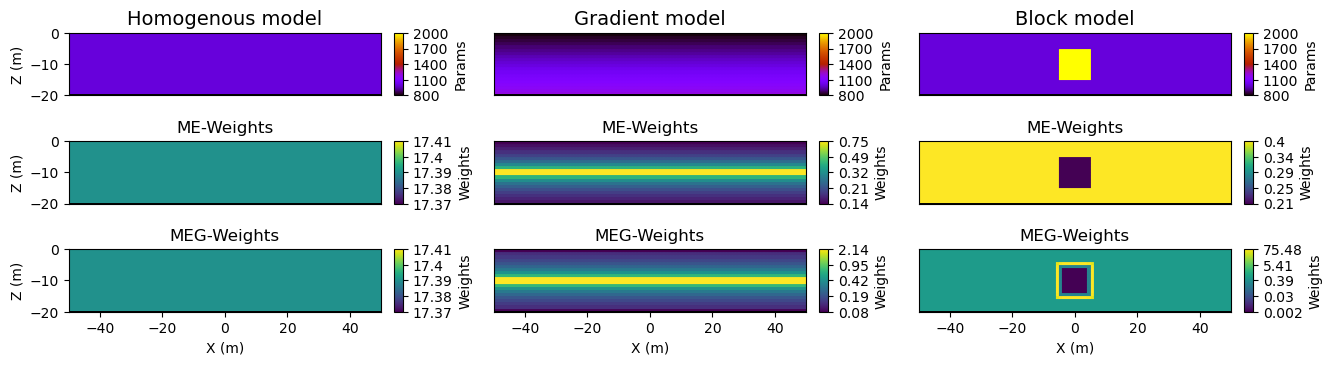

In [5]:
# %% show models
mesh = grid

q=1
b=1e-5

hom = 1000 * mesh.cellMarkers()
block = 1000 * mesh.cellMarkers()
for i, c in enumerate(mesh.cellCenters()):
    if abs(pg.x(c)) <=5:
        if pg.y(c)<-5 and pg.y(c)>-15:
            block[i]=2*block[i]
grad = 800 - (400/20)* pg.y(mesh.cellCenters())

# %% plot ME weights for different models
fig, ax = plt.subplots(3,3,figsize=(15,4))
# fig.tight_layout(pad=0.5)

tit = ['Homogenous model', 'Gradient model', 'Block model']
for i, mod in enumerate([hom, grad, block]):
    
    [m, m0] = normalize(mod, hom)
    grad_m = pg.solver.grad(mesh, m)
            
    Qeg = np.sum(np.linalg.norm(grad_m,axis=1)**q+b)
    weg = np.sqrt( 1/Qeg * 1/(b+abs(m-m0)**2) * (b+np.linalg.norm(grad_m,axis=1)**q)*
                  np.log(Qeg/(b+np.linalg.norm(grad_m,axis=1)**q)))
    
    Qe = np.sum(abs(m-m0)**q + b)
    we = np.sqrt( 1/Qe * 1/(b+abs(m-m0)**2) * (b+abs(m-m0)**q) * np.log(Qe/(b+abs(m-m0)**q)))
    
    
    pg.show(mesh, mod, ax=ax[0,i], cMap='gnuplot', orientation='vertical', cMin=800, cMax=2000, colorBar=False)
    pg.show(mesh, we, ax=ax[1,i], label='ME-Weights', orientation='vertical', logScale=True, colorBar=False)
    pg.show(mesh, weg, ax=ax[2,i], label='MEG-Weights', orientation='vertical', logScale=True, colorBar=False)
    ax[0,i].set_title(tit[i], fontsize=14); ax[1,i].set_title('ME-Weights'); ax[2,i].set_title('MEG-Weights')
    
    cax0 = ax[0,i].inset_axes([1.04, 0.0, 0.03, 1])
    createColorBarOnly(ax=cax0, cMin=800, cMax=2000, logScale=False,cMap='gnuplot',
                       label='Params', orientation='vertical')
    
    cax1 = ax[1,i].inset_axes([1.04, 0.0, 0.03, 1])
    createColorBarOnly(ax=cax1, logScale=True,cMap='viridis', cMin=min(we), cMax=max(we),
                       label='Weights', orientation='vertical')
    
    cax2 = ax[2,i].inset_axes([1.04, 0.0, 0.03, 1])
    createColorBarOnly(ax=cax2, logScale=True,cMap='viridis', cMin=min(weg), cMax=max(weg),
                       label='Weights', orientation='vertical')
    
    

for a1 in ax:
    for a in a1:
        a.set_xlim(-50,50)
for axis in ax[:,0]:
    axis.set_ylabel('Z (m)')
for axis in ax[-1,:]:
    axis.set_xlabel('X (m)')
for axis_ar in ax[:2,:]:
    for axis in axis_ar:
        axis.set_xticks([])
for axis_ar in ax[:,1:]:
    for axis in axis_ar:
        axis.set_yticks([])

plt.subplots_adjust(wspace=0.36, hspace=0.18)

# plt.savefig(path+'Figures/Ch-2/Simple_weights.pdf', dpi=600, bbox_inches='tight')

## Fig. 3: Joint Model Weights JME

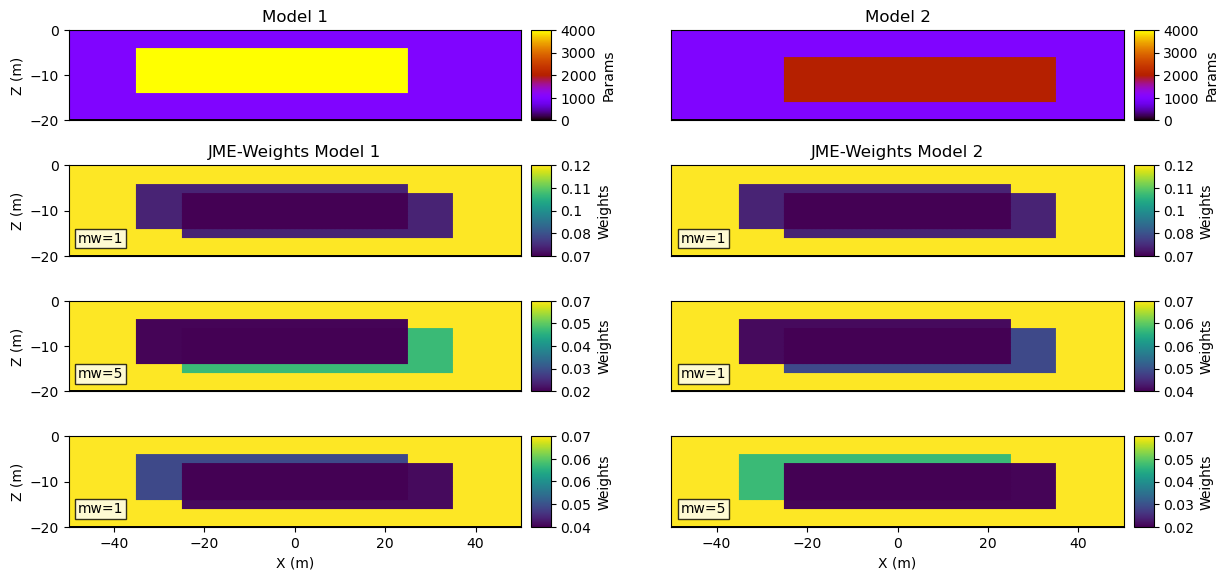

In [6]:
mesh = grid

hom = 1000 * mesh.cellMarkers()
block = 1000 * mesh.cellMarkers()
block2 = 1000 * mesh.cellMarkers()

for i, c in enumerate(mesh.cellCenters()):
    if pg.x(c) >=-35 and pg.x(c)<=25:
        if pg.y(c)<-4 and pg.y(c)>-14:
            block2[i]=4*block2[i]
    if pg.x(c)>=-25 and pg.x(c)<=35:
        if pg.y(c)<-6 and pg.y(c)>-16:
            block[i]=2*block[i]
            
# %% JME functions
mod1 = block2
mod2 = block
mw_list = [[1,1],[5,1],[1,5]]

q=1
b=1e-5

fig, ax = plt.subplots(4,2, figsize=(14,7))

pg.show(mesh, mod1, ax=ax[0,0], cMap='gnuplot', cMin=0, cMax=4000, orientation='vertical', label='Params')
pg.show(mesh, mod2, ax=ax[0,1], cMap='gnuplot', cMin=0, cMax=4000, orientation='vertical', label='Params')

ax[0,0].set_title('Model 1')
ax[0,1].set_title('Model 2')

ax[0,0].set_ylabel('Z (m)')
ax[0,1].set_yticks([])

ax[1,0].set_title('JME-Weights Model 1')
ax[1,1].set_title('JME-Weights Model 2')

for j, mw in enumerate(mw_list):
    Q_all = []
    for i, mod in enumerate([mod1, mod2]):

        cell_area = np.array(mesh.cellSizes())
        [m, m0] = normalize(mod, hom)
        Q = np.sum(mw[i]*abs(m-m0)**q + b)
        Q_all.append(Q)

    Q = sum(Q_all)

    [m1, m10] = normalize(mod1, hom)
    [m2, m20] = normalize(mod2, hom)

    we1 = np.sqrt( 1/Q * 1/(b+mw[0]*abs(m1-m10)**2) * (b+abs(m1-m10)**q) * np.log(Q/(b+mw[0]*abs(m1-m10)**q+mw[1]*abs(m2-m20)**q)))
    we2 = np.sqrt( 1/Q * 1/(b+mw[1]*abs(m2-m20)**2) * (b+abs(m2-m20)**q) * np.log(Q/(b+mw[0]*abs(m1-m10)**q+mw[1]*abs(m2-m20)**q)))
    
    pg.show(mesh, we1, ax=ax[j+1,0], orientation='vertical', logScale=True, #colorBar=False, 
            label='Weights')#, cMin=min([min(we1),min(we1)]), cMax=max([max(we1),max(we1)]))
    pg.show(mesh, we2, ax=ax[j+1,1], orientation='vertical', logScale=True, 
            label='Weights')#, cMin=min([min(we1),min(we1)]), cMax=max([max(we1),max(we1)]))
        
    ax[j+1,0].set_ylabel('Z (m)')
    ax[j+1,1].set_yticks([])
    
    ax[j+1,0].text(-48, -17, f'mw={mw[0]}' , fontsize=10,
                   bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2})
    ax[j+1,1].text(-48, -17, f'mw={mw[1]}' , fontsize=10,
                   bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2})
    

for a1 in ax:
    for a in a1:
        a.set_xlim(-50,50) 
for ax_ar in ax[:-1,:]:
    for axis in ax_ar:
        axis.set_xticks([])

ax[-1,0].set_xlabel('X (m)')
ax[-1,1].set_xlabel('X (m)')

plt.subplots_adjust(wspace=0.25, hspace=0.02)

# plt.savefig(path+'Figures/Ch-2/JME_weights.pdf', dpi=600, bbox_inches='tight')

# Additional Figures

## Illustration of cType = 10

06/11/23 - 15:20:15 - pyGIMLi - INFO - Found 1 regions.


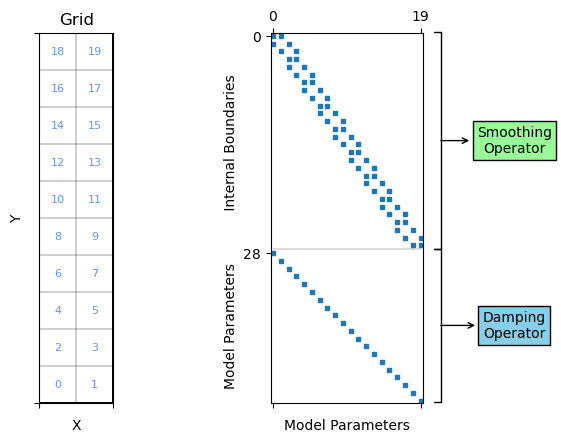

In [7]:
from pygimli.frameworks import PriorModelling

yn=np.arange(0,11,1).tolist()
xn=np.arange(0,2.5,1).tolist()
gridn = pg.createGrid(xn, yn, marker=1, worldBoundaryMarker=True)

pos = [[0.3, 3], [0.7, 1]]
vals = np.array([20., 5.])
fop = PriorModelling(gridn, pos)

inv = pg.Inversion(fop=fop, verbose=False)
invkw = dict(dataVals=vals, errorVals=np.ones_like(vals)*0.03, startModel=12)
plotkw = dict(cMap="Spectral_r", cMin=10, cMax=25)

inv.setRegularization(cType=10)  # mix of 1st order smoothing and damping
result = inv.run(**invkw)
C = fop.constraints()

fig,[ax1,ax2] = plt.subplots(1,2)
pg.show(gridn, **plotkw, colorBar=False, ax=ax1)
ax1.set_title("Grid")
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_yticks([0,len(yn)-1])

pg.show(fop.constraints(),markersize=3, ax=ax2)
ax2.set_xlabel('Model Parameters',labelpad=8)
ax2.set_ylabel('Model Parameters            Internal Boundaries      ')
ax2.set_yticks([0,28,48])
ax2.set_xticks([0,19])
ax2.set_xlim([-0.3,19.3])
ax2.set_ylim([47.3,-0.3])

ax2.annotate('Damping\nOperator', xy=(1.1, 0.21), xytext=(1.6, 0.21), xycoords='axes fraction', 
            ha='center', va='center',
            bbox=dict(boxstyle='square', fc='skyblue', color='k'),
            arrowprops=dict(arrowstyle='<-[, widthB=5.5, lengthB=.5, angleB=0', lw=1.0, color='k'))
ax2.annotate('Smoothing\nOperator', xy=(1.1, 0.71), xytext=(1.6, 0.71), xycoords='axes fraction', 
            ha='center', va='center',
            bbox=dict(boxstyle='square', fc='palegreen', color='k'),
            arrowprops=dict(arrowstyle='<-[, widthB=7.8, lengthB=.5, angleB=0', lw=1.0, color='k'))

ax2.plot([0,gridn.cellCount()-1],[27.5,27.5],'k', linewidth=0.2)


for i, c in enumerate(gridn.cellCenters()):
    ax1.text(c[0],c[1],f'{gridn.cells()[i].id()}',horizontalalignment='center',verticalalignment='center', fontsize=8, color='cornflowerblue')
    

# plt.savefig(path+'Figures/Ch-2/CType10.pdf', dpi=600, bbox_inches='tight')

## ME weights with order 1 to 3

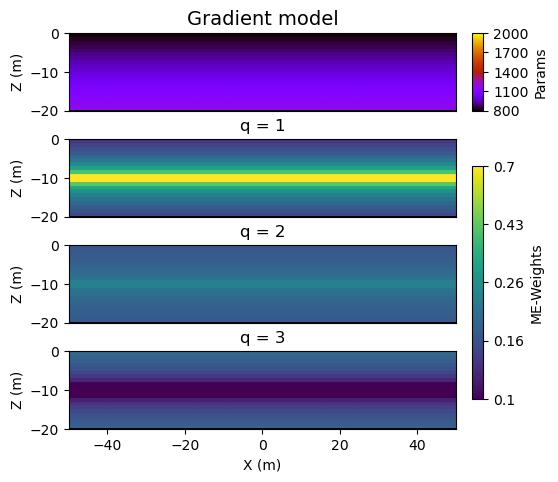

In [8]:
# %% show models
mesh = grid

q_list = [1,2,3]
b=1e-5

# %% plot ME weights for different models
fig, ax = plt.subplots(len(q_list)+1,1,figsize=(5,5.3))
# fig.tight_layout(pad=0.5)

tit = ['Homogenous model', 'Gradient model', 'Block model']

pg.show(mesh, grad, ax=ax[0], cMap='gnuplot', orientation='vertical', cMin=800, cMax=2000, colorBar=False)
ax[0].set_title( 'Gradient model', fontsize=14)
cax0 = ax[0].inset_axes([1.04, 0.0, 0.03, 1])
createColorBarOnly(ax=cax0, cMin=800, cMax=2000, logScale=False,cMap='gnuplot',
                    label='Params', orientation='vertical')
    
for j, q in enumerate(q_list):
    [m, m0] = normalize(grad, hom)
    Qe = np.sum(abs(m-m0)**q + b)
    we = np.sqrt( 1/Qe * 1/(b+abs(m-m0)**2) * (b+abs(m-m0)**q) * np.log(Qe/(b+abs(m-m0)**q)))

    pg.show(mesh, we, ax=ax[j+1], label='ME-Weights', orientation='vertical', logScale=True, colorBar=False, cMin=0.1, cMax=0.7)
        
    ax[j+1].set_title(f'q = {q}')

cax1 = ax[1].inset_axes([1.04, -2.35, 0.03, 3])
createColorBarOnly(ax=cax1, logScale=True,cMap='viridis', cMin=0.1, cMax=0.7,
                    label='ME-Weights', orientation='vertical')    
    
    

for a in ax:
    a.set_xlim(-50,50)
for a in ax:
    a.set_ylabel('Z (m)')
ax[-1].set_xlabel('X (m)')
for a in ax[:-1]:
    a.set_xticks([])


plt.subplots_adjust(wspace=0.36, hspace=0.18)

# plt.savefig(path+'Figures/Ch-2/Simple_weights_q123.pdf', dpi=600, bbox_inches='tight')

## JMEG weights

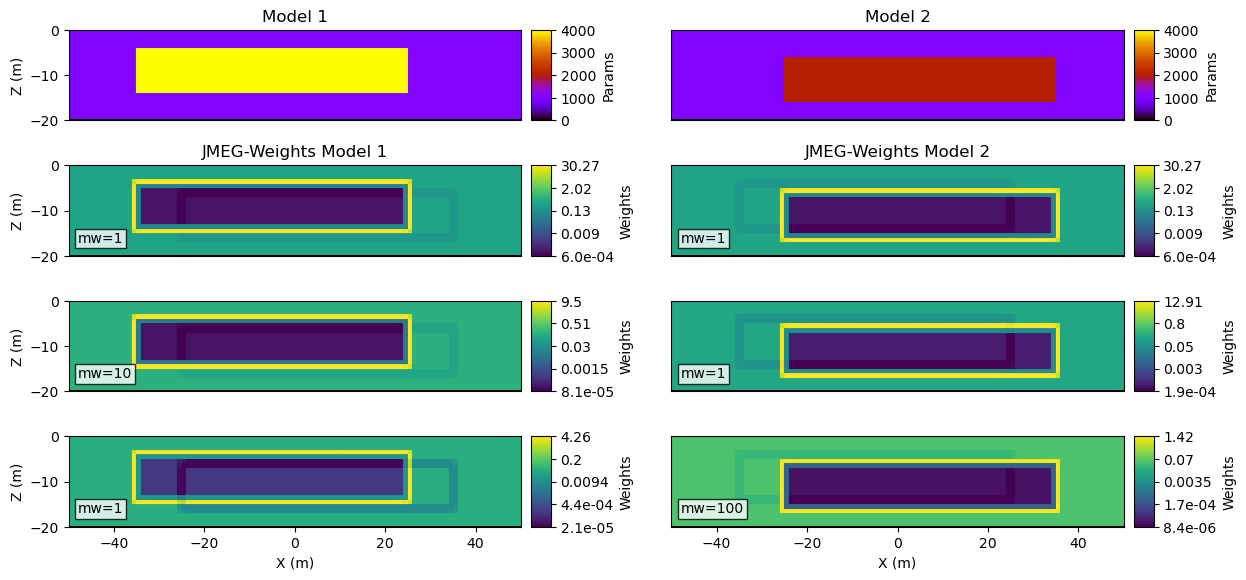

In [9]:
# %% JMEG functions
mod1 = block2
mod2 = block
mw_list = [[1,1],[10,1],[1,100]]

q=2
b=1e-5

fig, ax = plt.subplots(4,2, figsize=(14,7))

pg.show(mesh, mod1, ax=ax[0,0], cMap='gnuplot', cMin=0, cMax=4000, orientation='vertical', label='Params')
pg.show(mesh, mod2, ax=ax[0,1], cMap='gnuplot', cMin=0, cMax=4000, orientation='vertical', label='Params')

ax[0,0].set_title('Model 1')
ax[0,1].set_title('Model 2')

ax[0,0].set_ylabel('Z (m)')
ax[0,1].set_yticks([])

ax[1,0].set_title('JMEG-Weights Model 1')
ax[1,1].set_title('JMEG-Weights Model 2')

for j, mw in enumerate(mw_list):
    Q_all = []
    for i, mod in enumerate([mod1, mod2]):
        
        [m, m0] = normalize(mod, hom)
        grad_m = pg.solver.grad(mesh, m)
        Q = np.sum(mw[i]*np.linalg.norm(grad_m,axis=1)**q + b)
        Q_all.append(Q)

    Q = sum(Q_all)

    [m1, m10] = normalize(mod1, hom)
    [m2, m20] = normalize(mod2, hom)
    grad_m1 = pg.solver.grad(mesh, m1)
    grad_m2 = pg.solver.grad(mesh, m2)
    weg = np.sqrt( 1/Qeg * 1/(b+abs(m-m0)**2) * (b+np.linalg.norm(grad_m,axis=1)**q)*
                  np.log(Qeg/(b+np.linalg.norm(grad_m,axis=1)**q)))

    weg1 = np.sqrt(1/Q * 1/(b+mw[0]*abs(m1-m10)**2) * (b+np.linalg.norm(grad_m1,axis=1)**q)* 
                   np.log(Qeg/(b+mw[0]*np.linalg.norm(grad_m1,axis=1)**q+mw[1]*np.linalg.norm(grad_m2,axis=1)**q)))
    weg2 = np.sqrt(1/Q * 1/(b+mw[1]*abs(m2-m20)**2) * (b+np.linalg.norm(grad_m2,axis=1)**q)* 
                   np.log(Qeg/(b+mw[0]*np.linalg.norm(grad_m1,axis=1)**q+mw[1]*np.linalg.norm(grad_m2,axis=1)**q)))
    
    pg.show(mesh, weg1, ax=ax[j+1,0], orientation='vertical', logScale=True, label='Weights')#, cMin=4e-4, cMax=40)
    pg.show(mesh, weg2, ax=ax[j+1,1], orientation='vertical', logScale=True, label='Weights')#, cMin=4e-4, cMax=40)
    
    ax[j+1,0].set_ylabel('Z (m)')
    ax[j+1,1].set_yticks([])
    
    ax[j+1,0].text(-48, -17, f'mw={mw[0]}' , fontsize=10,
                   bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2})
    ax[j+1,1].text(-48, -17, f'mw={mw[1]}' , fontsize=10,
                   bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 2})

for a1 in ax:
    for a in a1:
        a.set_xlim(-50,50) 
for ax_ar in ax[:-1,:]:
    for axis in ax_ar:
        axis.set_xticks([])

ax[-1,0].set_xlabel('X (m)')
ax[-1,1].set_xlabel('X (m)')

plt.subplots_adjust(wspace=0.25, hspace=0.02)

# plt.savefig(path+'Figures/Ch-2/JMEG_weights.pdf', dpi=600, bbox_inches='tight')